In [1]:
import uproot
import numpy as np
import awkward as ak

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys

In [2]:
def getData(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"]
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict["hit_detID"].array(),
                                      "edep":    dq_dict["hit_edep"].array(),
                                      "elmID":   dq_dict["hit_elmID"].array(),
                                      "truthx":  dq_dict["hit_truthx"].array(),
                                      "truthy":  dq_dict["hit_truthy"].array(),
                                      "truthz":  dq_dict["hit_truthz"].array(),
                                      }),
                        "Electrons":ak.zip({
                                            "ge": dq_dict["ge"].array(),
                                            "gvx": dq_dict["gvx"].array(),
                                            "gvy": dq_dict["gvy"].array(),
                                            "gvz": dq_dict["gvz"].array(),
                                            "gpt": dq_dict["gpt"].array(),

                                        }),
                        "Showers":ak.zip({
                                        "nshowers": dq_dict["n_showers"].array(),
                                        "sedep_ecal": dq_dict["sedep_ecal"].array(),
                                        "sx": dq_dict["sx_ecal"].array(),
                                        "sy": dq_dict["sy_ecal"].array(),
                                        "sz": dq_dict["sz_ecal"].array(),
                                        }),
                        "st1_hits":ak.zip({
                                        "gx": dq_dict["gx_st1"].array(),
                                        "gy": dq_dict["gy_st1"].array(),
                                        "gz": dq_dict["gz_st1"].array(),
                                        }),
                        "st2_hits":ak.zip({
                                        "gx": dq_dict["gx_st2"].array(),
                                        "gy": dq_dict["gy_st2"].array(),
                                        "gz": dq_dict["gz_st2"].array(),
                                        }),
                        "h1_hits":ak.zip({
                                        "gx": dq_dict["gx_h1"].array(),
                                        "gy": dq_dict["gy_h1"].array(),
                                        "gz": dq_dict["gz_h1"].array(),
                                        }),
                        "h2_hits":ak.zip({
                                        "gx": dq_dict["gx_h2"].array(),
                                        "gy": dq_dict["gy_h2"].array(),
                                        "gz": dq_dict["gz_h2"].array(),
                                        }),
                        "h4_hits":ak.zip({
                                        "gx": dq_dict["gx_h4"].array(),
                                        "gy": dq_dict["gy_h4"].array(),
                                        "gz": dq_dict["gz_h4"].array(),
                                        }),
                        "emcal_hits":ak.zip({
                                        "gx": dq_dict["gx_ecal"].array(),
                                        "gy": dq_dict["gy_ecal"].array(),
                                        "gz": dq_dict["gz_ecal"].array(),
                                        "nhits": dq_dict["nhits_ecal"].array(),
                                        }),
                       }, depth_limit=1)
    return dq_events

In [3]:
def emcal_aselection(arr):
    mask = (arr.detID == 100)
    return mask

def h1bt_selection(arr):
    mask = (arr.detID >= 31) & (arr.detID <= 32)
    return mask

def h1lr_selection(arr):
    mask = (arr.detID >= 33) & (arr.detID <= 34)
    return mask

def h2lr_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 36)
    return mask

def h2bt_selection(arr):
    mask = (arr.detID >= 37) & (arr.detID <= 38)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h41lr_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 42)
    return mask

def h42lr_selection(arr):
    mask = (arr.detID >= 43) & (arr.detID <= 44)
    return mask

In [9]:
def studyAcc(ifile,title,acceptances,mass):
    dq_events = getData(ifile,"Truth")[:500]
    dq_hits = dq_events["Hits"]
    dq_showers = dq_events["Showers"]
    dq_electrons = dq_events["Electrons"]
    dq_emcalhits = dq_events["emcal_hits"]

    h4_hits = dq_hits[h41lr_selection(dq_hits)]
    
    dq_sh_z = ak.fill_none(ak.pad_none(dq_showers.sz, 2, axis=1),0)
    dq_sh_e = ak.fill_none(ak.pad_none(dq_showers.sedep_ecal, 2, axis=1),-1)
    dq_e_ge = ak.fill_none(ak.pad_none(dq_electrons.ge, 2, axis=1),-1)
    
    shower_zero_mask = ak.any(dq_sh_e==0,axis=1)
    shower_zero_index = np.where(shower_zero_mask)
   
    h4y_mask = (h4_hits.truthy <= -100) & (h4_hits.truthz >= 100)
    h4y_index = np.where(ak.any(h4y_mask,axis=1))

    sh_h4_mask = shower_zero_mask & h4y_mask
    sh_h4_index = np.where(ak.any(sh_h4_mask,axis=1))
    
    eshower_mask = ak.all(dq_sh_e > 0.1*dq_e_ge,axis=1)
    eshower_index = np.where(eshower_mask)
    
    masks = {
        'shower_zero':shower_zero_index,
        'h4y_hits':h4y_index,
        'h4y_and_showerzero': sh_h4_index,
        'eshower':eshower_index
    }
    
    den = 500
    #den = len(dq_events)
    dq_evts = dq_events[ak.all(dq_e_ge>-1,axis=1)]
    #den = len(dq_evts)
    print(mass,len(dq_evts),len(dq_events))
    for maskstr,m in masks.items():
        if maskstr in acceptances:
            acceptances[maskstr].append(len(m[0])/den)
        else:
            acceptances[maskstr] = [len(m[0])/den]
        #print(maskstr+':', len(m[0])/den)
    return acceptances

In [10]:
studyAcc('data/simana_electrons_Feb17/Eta_0.010502_z500_600_eps_-6.root',r'Eta m=0.54 GeV $v_z$:5-6 m',{},0.01)

0.01 185 500


{'shower_zero': [0.038],
 'h4y_hits': [0.0],
 'h4y_and_showerzero': [0.0],
 'eshower': [0.008]}

In [15]:
masses = {}
masses['Brem'] = ["0.011603","0.015117","0.025659","0.033428","0.043551","0.056739","0.073920",
                  "0.096304","0.125467","0.163460","0.212958","0.361459","0.470915","0.613515","0.799296",
                  "1.356670","1.767490","2.302710"
                 ]
masses['Eta'] = ["0.010502","0.012922","0.015900","0.019564","0.024072","0.029619","0.036445","0.044843","0.055176",
                 "0.067891","0.083535","0.102784","0.126469","0.155612","0.191470","0.235592","0.289880",
                 "0.540000"]
acceptances = {}
for proc in ["Brem","Eta"]:
    acceptances[proc] = {}
    print(proc)
    for mass in masses[proc]:
        ifile = "data/simana_electrons_Feb17/%s_%s_z500_600_eps_-6.root"%(proc,mass)
        studyAcc(ifile,'',acceptances[proc],mass)

Brem
0.011603 500 500
0.015117 500 500
0.025659 500 500
0.033428 500 500
0.043551 500 500
0.056739 500 500
0.073920 500 500
0.096304 500 500
0.125467 500 500
0.163460 500 500
0.212958 500 500
0.361459 500 500
0.470915 500 500
0.613515 500 500
0.799296 500 500
1.356670 500 500
1.767490 250 250
2.302710 10 10
Eta
0.010502 185 500
0.012922 316 500
0.015900 316 500
0.019564 279 500
0.024072 339 500
0.029619 347 500
0.036445 393 500
0.044843 392 500
0.055176 436 500
0.067891 458 500
0.083535 478 500
0.102784 495 500
0.126469 498 500
0.155612 500 500
0.191470 500 500
0.235592 500 500
0.289880 500 500
0.540000 500 500


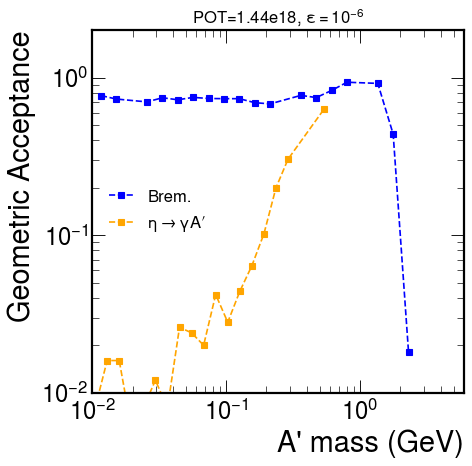

In [22]:
def plotAcceptance(masses,acceptances):
    fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=80)
    labels = {'Brem': 'Brem.',
              'Eta': r'$\eta \rightarrow \gamma A\prime$',
             }
    colors = {'Brem': ['blue'],
              'Eta': ['orange'],
              }
    for proc,acc in acceptances.items():
        masslist = [float(i) for i in masses[proc]]
        plt.plot(masslist,acc['eshower'], color=colors[proc][0], label=labels[proc], marker='s', linestyle='dashed')
        #r'$E_{dep}^{EMCAL}>0.1 E_{e^-}$'
        #plt.plot(masses,acc['shower_zero'],color='blue', label=r'Shower edep==0') #(same as w. ecal hits)')
        #plt.plot(masses,acc['h4y_hits'],color='green', label=r'St4 hits  (out of acceptance)')
    ax.set_xlabel("A' mass (GeV)")
    ax.set_ylabel(r"Geometric Acceptance")
    ax.set_xlim(0.01,6) 
    ax.set_ylim(0.01,2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(prop={'size': 15})
    ax.set_title('POT=1.44e18, $\epsilon=10^{-6}$', fontsize=15)
    plt.show()
    #plt.savefig('acceptance_%s%s.png'%(mech,tag))
    
plotAcceptance(masses,acceptances)

In [ ]:
def studyFail(ifile,title):
    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events["Hits"]
    dq_showers = dq_events["Showers"]
    dq_electrons = dq_events["Electrons"]
    dq_h4hits = dq_events["h4_hits"]
    dq_emcalhits = dq_events["emcal_hits"]
    dq_h2hits = dq_events["h2_hits"]
    dq_h1hits = dq_events["h1_hits"]
    dq_st1hits = dq_events["st1_hits"]
    dq_st2hits = dq_events["st2_hits"]
    
    # mask ecal showers with edep=0
    shower_zero_mask = ak.any(dq_showers.sedep_ecal==0,axis=1)
    shower_zero_index = np.where(shower_zero_mask)
    
    masks = {
        'shower_zero':shower_zero_index,
    }
    
    # let's check first evts that have edep=0 in shower
    fail_events = np.array(ak.flatten(np.where(shower_zero_mask)))
    print(len(fail_events)/len(dq_events))
    
    print('Showers in EMCAL')
    fig, axs = plt.subplots(1, 1, figsize=(12, 6))
    plt.hist(ak.flatten(dq_showers.sz),bins=100,range=[500,2500],histtype='step',label=r"All showers")
    plt.hist(ak.flatten(dq_showers[dq_showers.sedep_ecal==0].sz),bins=100,range=[500,2500],histtype='step',label=r"Shower with $E_{dep}=0$ @ EMCAL")
    axs.set_ylabel('Showers')
    axs.set_xlabel('Shower z position')
    axs.set_title(title)
    plt.legend()
    
    dq_sh_z = ak.fill_none(ak.pad_none(dq_showers.sz, 2, axis=1),0)
    dq_sh_e = ak.fill_none(ak.pad_none(dq_showers.sedep_ecal, 2, axis=1),-1)
    
    dq_sh_e_0 = dq_sh_e[:,0]
    dq_sh_z_0 = dq_sh_z[:,0]
    dq_e_0 = dq_electrons.ge[:,0]
    dq_z_0 = dq_electrons.gvz[:,0]

    dq_sh_e_1 = dq_sh_e[:,1]
    dq_sh_z_1 = dq_sh_z[:,1]
    dq_e_1 = dq_electrons.ge[:,1]
    dq_z_1 = dq_electrons.gvz[:,1]

    fig = plt.figure(figsize=(8,6))
    plt.hist(ak.to_list(dq_e_0),bins=100,histtype='step',label=r"$e^-$")
    plt.hist(ak.to_list(dq_e_1),bins=100,histtype='step',label=r"$e^+$")
    plt.xlabel('Electron Energy [GeV]')
    plt.ylabel('Electron Counts')
    plt.legend()
    plt.title('Electron energy')
    
    fig = plt.figure(figsize=(8,6))
    plt.hist(ak.to_list(dq_z_0),bins=100,histtype='step',label=r"$e^-$")
    plt.hist(ak.to_list(dq_z_1),bins=100,histtype='step',label=r"$e^+$")
    plt.xlabel('Electron vertex z [cm]')
    plt.ylabel('Electron Counts')
    plt.legend()
    plt.title('Electron z vertex')
    
    fig = plt.figure(figsize=(8,6))    
    plt.hist(ak.to_list(dq_sh_z_0[dq_sh_e_0>0]),bins=100,range=[500,2500], density=False, histtype='step',label='Edep EMCAL>0')
    plt.hist(ak.to_list(dq_sh_z_0[dq_sh_e_0==0]),bins=100,range=[500,2500], density=False, histtype='step',label='Edep EMCAL=0')
    plt.ylabel('Electron Energy [GeV]')
    plt.xlabel('Shower z position')
    plt.title('Shower z for e-')
    
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_sh_z[:,0]),ak.to_list(dq_electrons.ge[:,0]),bins=[100,100],range=[[500,2500],[0,50]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('Electron Energy [GeV]')
    plt.xlabel('Shower z position')
    plt.title(r'Shower z vs $e^-$ energy')
    
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_sh_z[:,1]),ak.to_list(dq_electrons.ge[:,1]),bins=[100,100],range=[[500,2500],[0,50]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('Positron Energy [GeV]')
    plt.xlabel('Shower z position')
    plt.title(r'Shower z vs $e^+$ energy')
    
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_sh_z_0[dq_sh_e_0==0]),ak.to_list(dq_e_0[dq_sh_e_0==0]),bins=[100,100],range=[[500,2500],[0,50]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('Electron Energy [GeV]')
    plt.xlabel('Shower z position')
    plt.title('Not EMCAL Shower z vs electron energy')
    
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_sh_z_1[dq_sh_e_1==0]),ak.to_list(dq_e_1[dq_sh_e_1==0]),bins=[100,100],range=[[500,2500],[0,50]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('Positron Energy [GeV]')
    plt.xlabel('Shower z position')
    plt.title('Not EMCAL Shower z vs positron energy')
    
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_sh_z_1[dq_sh_e_1==0]),ak.to_list(dq_z_1[dq_sh_e_1==0]),bins=[100,100],range=[[500,2500],[500,600]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('Electron vertex z [cm]')
    plt.xlabel('Shower z position [cm]')
    plt.title('Not EMCAL Shower z vs positron vz')
  
    dq_h1_x_0 = dq_h1hits[:,0].gx
    dq_h1_y_0 = dq_h1hits[:,0].gy
    dq_h1_z_0 = dq_h1hits[:,0].gz
    dq_h1_x_1 = dq_h1hits[:,1].gx
    dq_h1_y_1 = dq_h1hits[:,1].gy
    dq_h1_z_1 = dq_h1hits[:,1].gz
    
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_h1_x_0),ak.to_list(dq_h1_y_0),bins=[100,100],range=[[-150,150],[-150,150]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('H1T/B y position [cm]')
    plt.xlabel('H1T/B x position [cm]')
    plt.title(r'H1 for $e^-$')
    
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_h1_x_1),ak.to_list(dq_h1_y_1),bins=[100,100],range=[[-150,150],[-150,150]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('H1T/B y position [cm]')
    plt.xlabel('H1T/B x position [cm]')
    plt.title(r'H1 for $e^+$')
    
    dq_h2_x_0 = dq_h2hits[:,0].gx
    dq_h2_y_0 = dq_h2hits[:,0].gy
    dq_h2_z_0 = dq_h2hits[:,0].gz
    dq_h2_x_1 = dq_h2hits[:,1].gx
    dq_h2_y_1 = dq_h2hits[:,1].gy
    dq_h2_z_1 = dq_h2hits[:,1].gz 

    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_h2_x_0),ak.to_list(dq_h2_y_0),bins=[100,100],range=[[-150,150],[-150,150]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('H2T/B y position [cm]')
    plt.xlabel('H2T/B x position [cm]')
    plt.title(r'H2 for $e^-$')    

    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_h2_x_1),ak.to_list(dq_h2_y_1),bins=[100,100],range=[[-150,150],[-150,150]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('H2T/B y position [cm]')
    plt.xlabel('H2T/B x position [cm]')
    plt.title(r'H2 for $e^+$')   

    dq_h4_x_0 = dq_h4hits[:,0].gx
    dq_h4_y_0 = dq_h4hits[:,0].gy
    dq_h4_z_0 = dq_h4hits[:,0].gz
   
    dq_h4_x_1 = dq_h4hits[:,1].gx
    dq_h4_y_1 = dq_h4hits[:,1].gy
    dq_h4_z_1 = dq_h4hits[:,1].gz

    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_sh_z_0[dq_sh_e_0==0]),ak.to_list(dq_h4_x_0[dq_sh_e_0==0]),bins=[100,100],range=[[500,2500],[-500,500]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('H4T/B x position [cm]')
    plt.xlabel('Shower z position [cm]')
    plt.title(r'H4 for $e^-$ for EMCAL dep==0')
    
    fig = plt.figure(figsize=(8,6))
    plt.hist(ak.to_list(dq_h4_y_0[dq_h4_y_0<10000]),bins=100,range=[-200,200], density=False, histtype='step',label=r'$e^-$')
    plt.hist(ak.to_list(dq_h4_y_1[dq_h4_y_1<10000]),bins=100,range=[-200,200], density=False, histtype='step',label=r'$e^+$')
    plt.ylabel('Electron Counts')
    plt.xlabel('H4T/B y position [cm]')
    plt.title(title)
    plt.legend()
    
    fig = plt.figure(figsize=(8,6))
    print(dq_h4_y_0[112])
    print(dq_sh_e_0[112])
    print(np.where(dq_sh_e_0<=0))
    print(np.where((dq_sh_e_0<=0) & (dq_h4_x_0<10000)))
    print(dq_h4_y_0[(dq_sh_e_0<=0) & (dq_h4_x_0<10000)])
    plt.hist2d(ak.to_list(dq_h4_x_0[(dq_sh_e_0>0) & (dq_h4_x_0<10000)]),ak.to_list(dq_h4_y_0[(dq_sh_e_0>0) & (dq_h4_y_0<10000)]),bins=[100,100],range=[[-500,500],[-500,500]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('H4T/B y position [cm]')
    plt.xlabel('H4T/B x position [cm]')
    plt.title(title)
    
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(dq_h4_x_0[dq_sh_e_0==0]),ak.to_list(dq_h4_y_0[dq_sh_e_0==0]),bins=[100,100],range=[[-500,500],[-500,500]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('H4T/B y position [cm]')
    plt.xlabel('H4T/B x position [cm]')
    plt.title(title)
    
    h4_mask = h4_selection(dq_hits)
    st4_hits = dq_hits[h4_mask]
    y_mask = (st4_hits.truthy <= -100) & (st4_hits.truthz >= 100)
    y_index = np.where(ak.any(y_mask,axis=1))
    print(len(ak.flatten(y_index))/len(dq_events))
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(ak.to_list(ak.flatten(st4_hits.truthx[st4_hits.truthx<10000])),
               ak.to_list(ak.flatten(st4_hits.truthy[st4_hits.truthy<10000])),
               bins=[100,100],range=[[-200,200],[-200,200]], density=False, norm=colors.LogNorm())
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.ylabel('H4T/B y position [cm]')
    plt.xlabel('H4T/B x position [cm]')
    plt.title(title)
    plt.legend()
    

In [ ]:
studyAcc('data/simana_electrons/Brem_0.011603_z500_600_eps_-6_new.root',r'Brem m=0.01 GeV $v_z$:5-6 m')
